In [1]:
import pyphen
import string
import re
import collections

import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Flatten
import keras

import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.


In [6]:
%load_ext pep8_magic

The pep8_magic extension is already loaded. To reload it, use:
  %reload_ext pep8_magic


In [24]:
hypher = pyphen.Pyphen(lang='hu_HU')

In [2]:
def hyph_tags(word, hypher=pyphen.Pyphen(lang='hu_HU'), aslist=False):
    """Hyphenating classification of the characters in the word.
    {B(egin),M(iddle),E(nd),S(ingle)}"""
    if (len(word) == 0):
        raise IndexError("0 length word")
    ret = list('M' * len(word))
    ret[0] = 'B'
    ret[-1] = 'E'
    for i in hypher.positions(word):
        ret[i] = 'B'
        if(ret[i-1] == 'B'):
            ret[i-1] = 'S'
        else:
            ret[i-1] = 'E'
    if (aslist):
        return ret
    return "".join(ret)


def hyph_tags_4to2(word, aslist=False):
    """{B,M,E,S} to {B, M}"""
    ret = list(word)
    for i in range(len(ret)):
        if ret[i] == 'S':
            ret[i] = 'B'
        if ret[i] != 'B':
            ret[i] = 'M'
    if(aslist):
        return ret
    return "".join(ret)


def same_char_num(word, hypher=pyphen.Pyphen(lang='hu_HU')):
    """Return true if the hyphenated word has as many chars as the original"""
    return len(hypher.inserted(word)) == len(word)+len(hypher.positions(word))


def cleaning(data):
    """Text cleaning:
        lower the letters
        punctuation, digits ellimination"""
    formated_data = data.lower()
    formated_data = re.sub('['+string.punctuation+']', '', formated_data)
    formated_data = re.sub('['+string.digits+']', '', formated_data)
    return formated_data

# Data import

In [49]:
tail_cut = 100000

In [50]:
tail_cut_ptest_words =tail_cut+500

counter_hu_data = collections.Counter()
word_list = []
c_all = 0
c_same_char_num = 0
with open('web2.2-freq-sorted.txt', 'r',
          errors='ignore', encoding='latin2') as f:
    i = 0
    for line in f:
        i = i+1
        words = line.split()
        if len(words) > 1:
            if(words[1].isdigit()):
                counter_hu_data[cleaning(words[0])] += int(words[1])
        if i > tail_cut_ptest_words:
            break
for words in counter_hu_data.most_common(tail_cut):
    c_all += 1
    next_word = words[0]
    if(len(next_word) != 0 and same_char_num(next_word)):
        c_same_char_num += 1
        word_list.append([next_word, hyph_tags_4to2(hyph_tags(next_word))])

In [5]:
print(c_same_char_num, c_all, c_same_char_num/c_all)

82563 83678 0.9866751117378523


In [6]:
print(word_list[100:200])

[['ember', 'BMBMM'], ['ezek', 'BMMM'], ['tovább', 'BMBMMM'], ['vagyok', 'BMBMMM'], ['ma', 'BM'], ['miatt', 'BMBMM'], ['this', 'BMMM'], ['mellett', 'BMMBMMM'], ['vannak', 'BMMBMM'], ['by', 'BM'], ['alapján', 'BMMMBMM'], ['lenne', 'BMMBM'], ['with', 'BMMM'], ['that', 'BMMM'], ['tehát', 'BMBMM'], ['te', 'BM'], ['it', 'BM'], ['ben', 'BMM'], ['egész', 'BMMMM'], ['néhány', 'BMBMMM'], ['milyen', 'BMBMMM'], ['át', 'BM'], ['nekem', 'BMBMM'], ['előtt', 'BMMMM'], ['ezzel', 'BMBMM'], ['mivel', 'BMBMM'], ['ezen', 'BMMM'], ['nélkül', 'BMMBMM'], ['lett', 'BMMM'], ['stb', 'BMM'], ['you', 'BMM'], ['viszont', 'BMBMMMM'], ['év', 'BM'], ['teljes', 'BMMBMM'], ['erre', 'BMBM'], ['hiszen', 'BMBMMM'], ['másik', 'BMBMM'], ['ebben', 'BMBMM'], ['mind', 'BMMM'], ['der', 'BMM'], ['három', 'BMBMM'], ['talán', 'BMBMM'], ['valami', 'BMBMBM'], ['die', 'BMM'], ['bár', 'BMM'], ['are', 'BMM'], ['legyen', 'BMBMMM'], ['tudom', 'BMBMM'], ['from', 'BMMM'], ['inkább', 'BMBMMM'], ['során', 'BMBMM'], ['például', 'BMMBMBM'], ['r

# Data preparation

In [7]:
# onehot: {'B','M','E','S'}
def one_hot_encode(char, dictionary='BMES'):
    ret = [0]*len(dictionary)
    if char in dictionary:
        ret[dictionary.find(char)] = 1
        return ret
    raise ValueError('Value out of dictionary range: '+char)


def unison_shuffled_copies(a, b):
    """Randomize 2 same length array in the same permutation"""
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


def one_hot_decode(arr, dictionary='BMES'):
    assert len(arr) == len(dictionary)
    i = np.nonzero(arr)[0][0]
    return dictionary[i]

In [8]:
hun_chars = 'aábcdeéfghiíjklmnoóöőpqrstuúüűvwxyz' + '^$'  # ^,$


def generate_network_data(data, ret_input=[], ret_output=[],
                          length=2, length_after=0,
                          start_char='^', end_char='$',
                          chars=hun_chars, tag_chars='BMES'):
    """from [word,hyph_class(word) to length-long input-output data"""
    word = data[0]
    word_plus = start_char*(length-length_after-1)+word+end_char*length_after
    hyph_word = data[1]
    for i in range(0, len(word)):
        input_next_iter = []
        for c in word_plus[i:i+length]:
            input_next_iter.append(one_hot_encode(c, chars))
        output_next_iter = one_hot_encode(hyph_word[i], tag_chars)
        ret_input.append(input_next_iter)
        ret_output.append(output_next_iter)

In [9]:
wc_in = []
wc_out = []

generate_network_data(['alma', 'BEBE'], wc_in, wc_out, 3, 1)
print(wc_in[0], wc_out[0])

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] [1, 0, 0, 0]


In [10]:
window_length = 5
length_after = 2
tag_chars = 'BM'

In [11]:
data_in = []
data_out = []
wrong_word = 0
for word in word_list:
    try:
        generate_network_data(word, data_in, data_out,
                              window_length, tag_chars=tag_chars,
                              length_after=length_after)
    except ValueError:
        wrong_word += 1
print('Data len: ', len(data_in))
print('Wrong words: ', wrong_word)

Data len:  698570
Wrong words:  646


In [12]:
valid_rate = 0.2
test_rate = 0.1
data_len = len(data_in)

data_in = np.array(data_in, dtype='float32')
data_out = np.array(data_out, dtype='float32')
data_in, data_out = unison_shuffled_copies(data_in, data_out)
tests_input = data_in[0:int(data_len*test_rate)]
tests_target = data_out[0:int(data_len*test_rate)]
valid_input = data_in[int(data_len*test_rate):
                      int(data_len*(test_rate+valid_rate))]
valid_target = data_out[int(data_len*test_rate):
                        int(data_len*(test_rate+valid_rate))]
train_input = data_in[int(data_len*(test_rate+valid_rate)):]
train_target = data_out[int(data_len*(test_rate+valid_rate)):]


print('Training data size:', np.shape(train_input), np.shape(train_target))
print('Validation data size:', np.shape(valid_input), np.shape(valid_target))
print('Test data size:', np.shape(tests_input), np.shape(tests_target))

Training data size: (488999, 5, 37) (488999, 2)
Validation data size: (139714, 5, 37) (139714, 2)
Test data size: (69857, 5, 37) (69857, 2)


In [30]:
train_input_flatten = np.reshape(
    train_input, (len(train_input), (window_length)*len(hun_chars)))
valid_input_flatten = np.reshape(
    valid_input, (len(valid_input), (window_length)*len(hun_chars)))
tests_input_flatten = np.reshape(
    tests_input, (len(tests_input), (window_length)*len(hun_chars)))

# DNN Model

In [43]:
num_layers = 2
num_hidden = 10

In [46]:
model = Sequential()
model.add(Dense(input_dim=((window_length)*len(hun_chars)),
                units=num_hidden, name='input_layer', activation='sigmoid'))
for i in range(1,num_layers):
    model.add(Dense(units=num_hidden, activation='sigmoid'))

# model.add(Flatten())
model.add(Dense(2, name='output_layer', activation='softmax'))

In [15]:
train_input_flatten.shape

(488999, 185)

In [16]:
earlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=0, mode='auto')

In [51]:
model.compile(loss='binary_crossentropy', optimizer='adam')

In [57]:
history = model.fit(train_input_flatten, train_target,
                    epochs=10, batch_size=1024,
                    validation_data=(valid_input_flatten, valid_target),
                    verbose=0, callbacks=[earlyStopping])

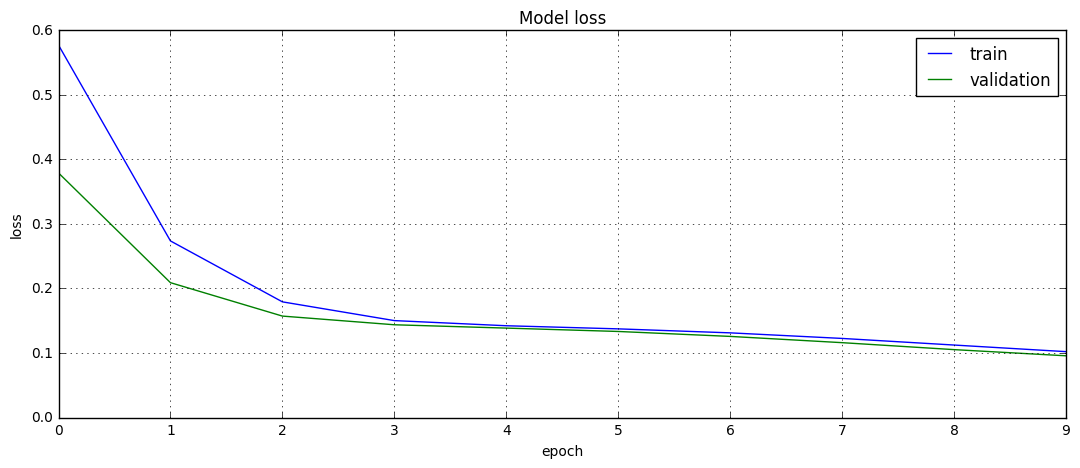

In [58]:
# summarize history for loss
plt.figure(figsize=(13, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
#plt.ylim((0.04, 0.06))
plt.grid()
plt.show()

In [42]:
print(history.history['val_loss'][-1:], history.epoch[-1])

[0.061144390774516874] 9


In [41]:
test_results = model.predict(tests_input_flatten)
test_success = 0
test_fail = 0
for i in range(len(test_results)):
    if np.argmax(test_results[i])==np.argmax(tests_target[i]):
        test_success +=1
    else:
        test_fail +=1
print(test_fail/(test_fail+test_success))

0.018351775770502596


In [22]:
def hpyh_predict(word, model,
                 length=2, length_after=0, tag_chars='BMES', aslist=False):
    """Generate tagging from the input word according to the model"""
    word_in = []
    word_out = []
    generate_network_data([word, len(word)*tag_chars[0]],
                          word_in, word_out, length=length,
                          length_after=length_after, tag_chars=tag_chars)
    word_in = np.reshape(word_in, (len(word_in), (length)*len(hun_chars)))
    word_out = model.predict(word_in)
    tag_list = np.array(list(tag_chars))
    temp = np.argmax(word_out, axis=1)
    temp = tag_list[temp]
    if(aslist):
        return temp
    return "".join(temp)

In [25]:
test = 'szemüveg'
print('Word:', test, 'Prediction:',
      hpyh_predict(test, model, window_length, length_after, tag_chars),
      'Target:', hyph_tags_4to2(hyph_tags(test)), hypher.inserted(test))

test = 'leopárd'
print('Word:', test, 'Prediction:',
      hpyh_predict(test, model, window_length, length_after, tag_chars),
      'Target:', hyph_tags_4to2(hyph_tags(test)), hypher.inserted(test))

Word: szemüveg Prediction: BMMBMBMM Target: BMMMBMMM szem-üveg
Word: leopárd Prediction: BMBBMMM Target: BMBBMMM le-o-párd


In [26]:
test_words = counter_hu_data.most_common()[-500:]
print('Word\tSuccess\tPrediction\tTarget\tVisualization')
for word in test_words:
    next_word = word[0]
    if(len(next_word) != 0 and same_char_num(next_word)):
        try:
            predicted_value = hpyh_predict(next_word, model,
                                           window_length, length_after,
                                           tag_chars)
            excepted_value = hyph_tags_4to2(hyph_tags(next_word))
            success = predicted_value == excepted_value
            if not success:
                print(next_word, '\t', success, '\t', predicted_value,
                      '\t', excepted_value, '\t', hypher.inserted(next_word))
        except ValueError as e:
            print(str(e))

Word	Success	Prediction	Target	Visualization
Value out of dictionary range: ŕ
szabadidőt 	 False 	 BMMBMBMBMM 	 BMMBMMBMMM 	 sza-bad-időt
közigazgatásilag 	 False 	 BMBBBMMBMBMBMBMM 	 BMMBMMMBMBMBMBMM 	 köz-igaz-ga-tá-si-lag
oleg 	 False 	 BMMM 	 BMBM 	 ol-eg
rózsafüzér 	 False 	 BMBMMBMMMM 	 BMBMMBMBMM 	 ró-zsa-fü-zér
táncszínház 	 False 	 BMMMMMMMBMM 	 BMMMBMMMBMM 	 tánc-szín-ház
együttérzést 	 False 	 BMMMMBMMBMMM 	 BMMMMMBMBMMM 	 együtt-ér-zést
geboren 	 False 	 BMBMBMM 	 BMBMMMM 	 ge-boren
felosztva 	 False 	 BMBMMMMBM 	 BMMBMMMBM 	 fel-oszt-va
beizzik 	 False 	 BMMMBMM 	 BMBMBMM 	 be-iz-zik
integratív 	 False 	 BMBMMBMBMM 	 BMBMBMMBMM 	 in-te-gra-tív
Value out of dictionary range: ô
jogegyenlőség 	 False 	 BMBBMMMMBMBMM 	 BMMBMMMMBMBMM 	 jog-egyen-lő-ség
információforrások 	 False 	 BMBMMBMBMBBMMBMBMM 	 BMBMMBMBMMBMMBMBMM 	 in-for-má-ció-for-rá-sok
perspektívából 	 False 	 BMMBBMMBMBMBMM 	 BMMMBMMBMBMBMM 	 pers-pek-tí-vá-ból
kialakít 	 False 	 BMBBMBMM 	 BMBMMBMM 	 ki-ala-kít
que

In [39]:
a =np.argmax(test_results[40])
b =np.argmax(tests_target[40])
print(a,b)

1 1


In [80]:
def model_creator(window_length, output_length, num_layers=1,
                  num_hidden=10, chars=hun_chars):
    """Creates Keras model with the given input, output dimensions
    and layer number, hidden layer length"""
    model = Sequential()
    model.add(Dense(input_dim=((window_length)*len(chars)),
                    units=num_hidden, name='input_layer', activation='sigmoid'))
    for i in range(1,num_layers):
        model.add(Dense(units=num_hidden, activation='sigmoid'))

    # model.add(Flatten())
    model.add(Dense(output_length, name='output_layer', activation='softmax'))

    if(output_length==2):
        model.compile(loss='binary_crossentropy', optimizer='adam')
    else:
        model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

In [65]:
model = model_creator(window_length,len(tag_chars),num_layers,num_hidden)

In [66]:
len(tag_chars)

2

In [74]:
def data_reader(file):
    """Read data from file"""

    counter_hu_data = collections.Counter()
    with open('web2.2-freq-sorted.txt', 'r',
              errors='ignore', encoding='latin2') as f:
        i = 0
        for line in f:
            i = i+1
            words = line.split()
            if len(words) > 1:
                if(words[1].isdigit()):
                    counter_hu_data[cleaning(words[0])] += int(words[1])
            if i > tail_cut_ptest_words:
                break
    return counter_hu_data


def train_data_generator(data_counter, window_length, length_after, 
                         tag_chars='BM', tail_cut=100000):
    """Generate training data from counter data"""
    tail_cut_ptest_words =tail_cut+500
    
    word_list = []
    c_all = 0
    c_same_char_num = 0
    
    for words in data_counter.most_common(tail_cut):
        c_all += 1
        next_word = words[0]
        if(len(next_word) != 0 and same_char_num(next_word)):
            c_same_char_num += 1
            if(len(tag_chars)==2):
                word_list.append([next_word, 
                                  hyph_tags_4to2(hyph_tags(next_word))])
            else:
                word_list.append([next_word, hyph_tags(next_word)])
    print('Data read successfully')
    print(c_same_char_num, c_all, c_same_char_num/c_all)
    
    # Generate network data
    data_in = []
    data_out = []
    wrong_word = 0
    for word in word_list:
        try:
            generate_network_data(word, data_in, data_out,
                                  window_length, tag_chars=tag_chars,
                                  length_after=length_after)
        except ValueError:
            wrong_word += 1
    print('Data len: ', len(data_in))
    print('Wrong words: ', wrong_word)
    

    valid_rate = 0.2
    test_rate = 0.1
    data_len = len(data_in)

    data_in = np.array(data_in, dtype='float32')
    data_out = np.array(data_out, dtype='float32')
    data_in, data_out = unison_shuffled_copies(data_in, data_out)
    tests_input = data_in[0:int(data_len*test_rate)]
    tests_target = data_out[0:int(data_len*test_rate)]
    valid_input = data_in[int(data_len*test_rate):
                          int(data_len*(test_rate+valid_rate))]
    valid_target = data_out[int(data_len*test_rate):
                            int(data_len*(test_rate+valid_rate))]
    train_input = data_in[int(data_len*(test_rate+valid_rate)):]
    train_target = data_out[int(data_len*(test_rate+valid_rate)):]
    
    
    print('Training data size:', np.shape(train_input), np.shape(train_target))
    print('Validation data size:', np.shape(valid_input), np.shape(valid_target))
    print('Test data size:', np.shape(tests_input), np.shape(tests_target))


    train_input_flatten = np.reshape(
        train_input, (len(train_input), (window_length)*len(hun_chars)))
    valid_input_flatten = np.reshape(
        valid_input, (len(valid_input), (window_length)*len(hun_chars)))
    tests_input_flatten = np.reshape(
        tests_input, (len(tests_input), (window_length)*len(hun_chars)))
    print('Network data generated successfully')
    
    return [train_input_flatten, train_target,
            valid_input_flatten, valid_target,
            tests_input_flatten, tests_target]

In [79]:
counter_hu_data = data_reader('web2.2-freq-sorted.txt')
[train_input_flatten, train_target,
 valid_input_flatten, valid_target,
 tests_input_flatten, tests_target] = train_data_generator(counter_hu_data,
                                                           window_length, 
                                                           length_after, 
                                                           tag_chars)

Data read successfully
82563 83678 0.9866751117378523
Data len:  698570
Wrong words:  646
Training data size: (488999, 5, 37) (488999, 2)
Validation data size: (139714, 5, 37) (139714, 2)
Test data size: (69857, 5, 37) (69857, 2)
Network data generated successfully


In [78]:
tests_input_flatten.shape

(69857, 185)

In [95]:
with open("results.txt", "a") as myfile:
    result = ""
    result += str(window_length) + '\t' + str(length_after) + '\t' + tag_chars
    result += '\t' + str(num_layers) + '\t' + str(num_hidden) + '\t'
    result += str(history.epoch[-1]) + '\t' + str(history.history['val_loss'][-1])
    result += '\t' + str(test_fail/(test_fail+test_success)) + '\n'
    myfile.write(result)

In [97]:
for i in range(10,101,10):
    print(i)

10
20
30
40
50
60
70
80
90
100


In [89]:
result

'5\t2\tBM\t2\t10\t9\t0.0955370114686\t0.018351775770502596'